In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.utils import resample

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Vishnu Bharadwaj
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Vishnu Bharadwaj
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Load dataset
df = pd.read_csv('Hate_Speech.csv')  # Replace with your filename

In [4]:
# Preprocessing function
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'@\w+|http\S+|[^a-zA-Z\s]', '', text)  # Remove mentions/URLs
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = re.sub(r'&\w+;', '', text)  # Remove HTML entities
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words and len(word) > 1]
    return ' '.join(filtered_words)

In [5]:
# Apply preprocessing
df['cleaned_text'] = df['tweet'].apply(preprocess_text)

In [6]:
# Separate majority and minority classes
df_majority = df[df['class'] == 2]  # Most samples (assume class 2 is majority)
df_minority1 = df[df['class'] == 0]  # Few samples (hate speech)
df_minority2 = df[df['class'] == 1]  # Few samples (offensive language)

# Upsample minority class
df_minority1_upsampled = resample(
    df_minority1, 
    replace=True,     # Sample with replacement
    n_samples=len(df_majority),    # To match majority class
    random_state=42
)

df_minority2_upsampled = resample(
    df_minority2, 
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# Combine majority and upsampled minority
df_balanced = pd.concat([df_majority, df_minority1_upsampled, df_minority2_upsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['class'].value_counts())  # To check class balance

class
1    4163
0    4163
2    4163
Name: count, dtype: int64


In [7]:
# Check class distribution
print("Class distribution:")
print(df['class'].value_counts())

Class distribution:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64


In [8]:
# Split data
X = df_balanced['cleaned_text']
y = df_balanced['class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

In [9]:
# Convert labels to categorical (3 classes)
NUM_CLASSES = 3
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)

In [10]:
# Tokenization and padding
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [11]:
# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

Loaded 400000 word vectors from GloVe.


In [12]:
embedding_dim = 100  # Because GloVe 100d

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [13]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [14]:
# Handle class imbalance
class_counts = np.bincount(df['class'])
total_samples = len(df)
class_weights = {
    0: total_samples / (NUM_CLASSES * class_counts[0]),
    1: total_samples / (NUM_CLASSES * class_counts[1]),
    2: total_samples / (NUM_CLASSES * class_counts[2])
}
print("\nClass weights:", class_weights)


Class weights: {0: 5.776923076923077, 1: 0.43048462741010945, 2: 1.9843862599087196}


In [15]:
# Build LSTM model
model = Sequential()
model.add(Embedding(
    input_dim=max_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation='softmax'))


In [16]:
# Custom weighted loss function
def weighted_loss(y_true, y_pred):
    weights = tf.constant([class_weights[0], class_weights[1], class_weights[2]], dtype=tf.float32)
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_ce = ce * tf.reduce_sum(y_true * weights, axis=1)
    return tf.reduce_mean(weighted_ce)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_loss,
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [17]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',   # Important for accuracy!
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)

In [18]:
# Train model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/20
313/313 [==============================] - 36s 52ms/step - loss: 1.3672 - accuracy: 0.5286 - precision: 0.5422 - recall: 0.5081 - val_loss: 1.0160 - val_accuracy: 0.5697 - val_precision: 0.5842 - val_recall: 0.5528 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 15s 46ms/step - loss: 0.9549 - accuracy: 0.6290 - precision: 0.6448 - recall: 0.6032 - val_loss: 0.8189 - val_accuracy: 0.6689 - val_precision: 0.6769 - val_recall: 0.6417 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 14s 46ms/step - loss: 0.7635 - accuracy: 0.7051 - precision: 0.7149 - recall: 0.6846 - val_loss: 0.6919 - val_accuracy: 0.7558 - val_precision: 0.7667 - val_recall: 0.7366 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - 15s 47ms/step - loss: 0.6219 - accuracy: 0.7636 - precision: 0.7693 - recall: 0.7524 - val_loss: 0.6615 - val_accuracy: 0.7386 - val_precision: 0.7460 - val_recall: 0.7302 - lr: 0.0010
Epoch 5/20
313/313 [========================

In [19]:
# Evaluation
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

79/79 [==============================] - 4s 21ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       832
           1       0.96      0.76      0.85       833
           2       0.90      0.93      0.92       833

    accuracy                           0.89      2498
   macro avg       0.90      0.89      0.89      2498
weighted avg       0.90      0.89      0.89      2498


Confusion Matrix:
[[814  11   7]
 [126 631  76]
 [ 39  18 776]]


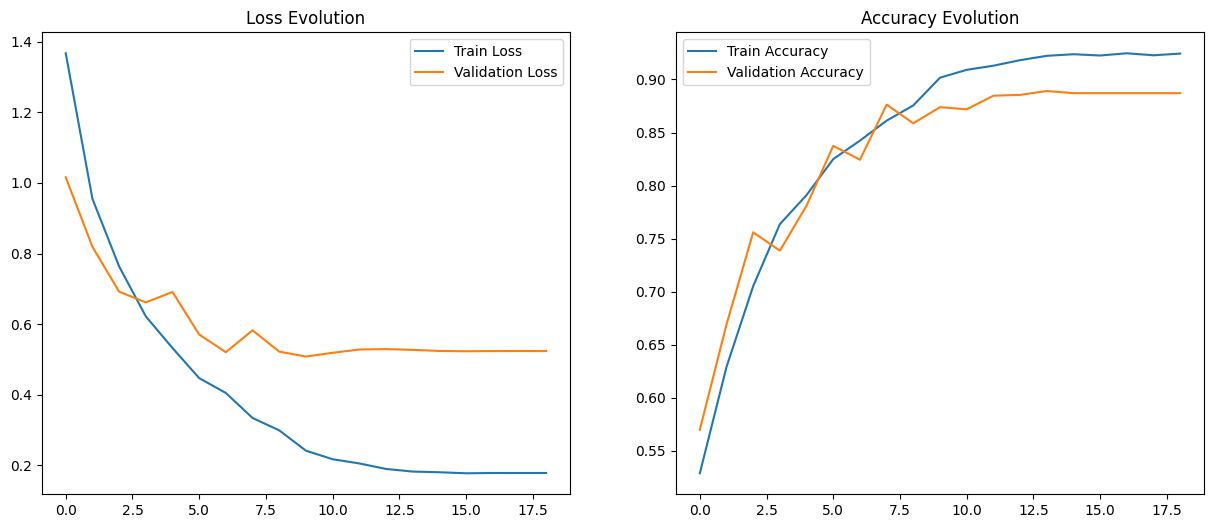

In [20]:
# Plot training history
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.show()